# Ensemble

In [1]:
%matplotlib inline

import itertools
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

C:\Users\samsung\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [70]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target

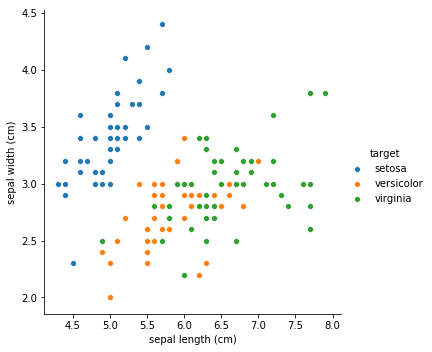

In [59]:
iris_plot = pd.DataFrame(data=np.c_[iris['data'],iris['target']],columns = iris['feature_names']+['target'])
iris_plot['target'] = iris_plot['target'].map({0:"setosa", 1:"versicolor",2:"virginia"})

sns.pairplot(iris_plot,x_vars=["sepal length (cm)"],y_vars=["sepal width (cm)"],hue='target', size = 5)

# 1. Parallel Ensemble

### Decision Tree, Bagging, Random Forest

### (1) Default

In [71]:
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
clf3 = RandomForestClassifier(random_state=0, n_estimators=10, max_features=0.8, criterion ='entropy')

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.67 (+/- 0.03) [Bagging Tree]
Accuracy: 0.69 (+/- 0.02) [Random Forest]


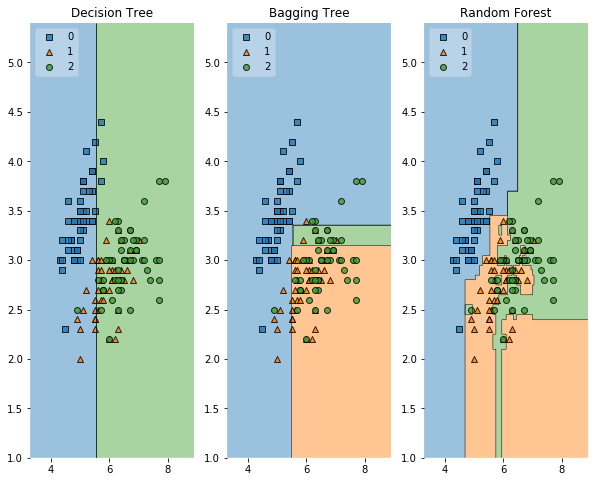

In [4]:
label = ['Decision Tree', 'Bagging Tree', 'Random Forest']
clf_list = [clf1, clf2, clf3]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 3)
grid = itertools.product([0,1,2],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

#### 단일 tree모형보다 배깅 트리가, 배깅트리보단 랜덤포레스트가 더 높은 정확도를 보임

### (2) Tuned

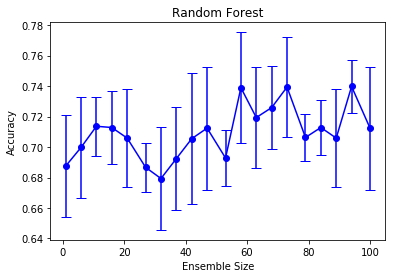

In [5]:
#Ensemble Size
num_est = np.linspace(1,100,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = RandomForestClassifier(n_estimators=n_est, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
    
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Random Forest');
plt.show()

In [72]:
clf4 = RandomForestClassifier(random_state=0, n_estimators=60, max_features=0.8, criterion ='entropy')

Accuracy: 0.73 (+/- 0.03) [Random Forest_tuning]


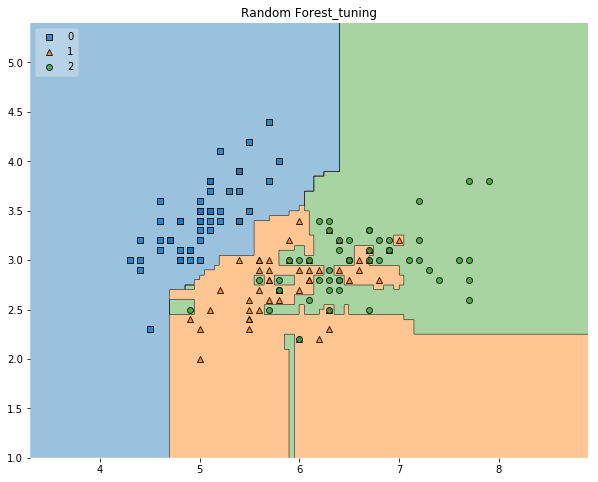

In [7]:
label = ['Random Forest_tuning']
clf_list = [clf4]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 1)

for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

#### 일부 parameter를 tuning한 랜덤포레스트. 예측력이 상승됨

### by Randomized Search

In [8]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=3)
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [9]:
est = RandomForestClassifier(n_jobs=-1)

rf_p_dist={'max_depth':[3,5,10,None],
               'criterion':['entropy'],
               'bootstrap':[True,False],
               'min_samples_leaf':randint(1,10)
              }

rf_parameters = hypertuning_rscv(est, rf_p_dist, 40, X, y)
print(rf_parameters)

({'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5}, 0.7733333333333333)


Accuracy: 0.79 (+/- 0.03) [RandomForest_RandomnizedCV]


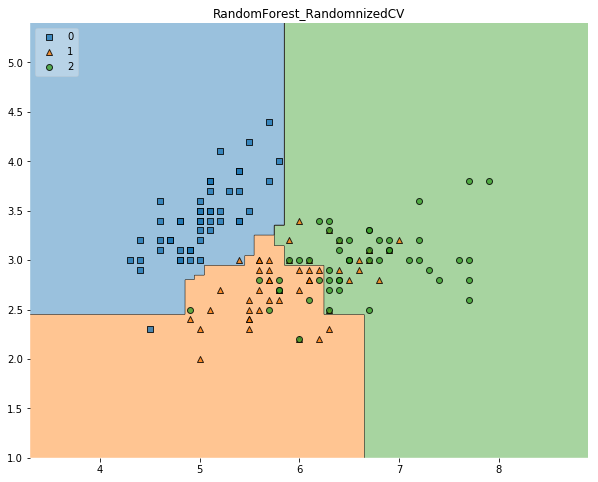

In [10]:
clf5 = RandomForestClassifier(max_depth = 3, min_samples_leaf = 7,bootstrap=True,criterion='entropy', n_estimators = 500)

clf_list = [clf5]
label = ['RandomForest_RandomnizedCV']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 1)

for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    
    clf.fit(X, y)
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

#### Randomized Search를 거친 랜덤포레스트. 예측력이 제일 높음.

# 2. Sequential Ensemble : Boosting

In [61]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgbm

### 1. Adaboost, GBM

### (1) default

In [74]:
clf6 = AdaBoostClassifier(n_estimators=1)
clf7 = GradientBoostingClassifier(random_state=0, n_estimators=1,  max_features=0.8)

Accuracy: 0.63 (+/- 0.02) [AdaBoost (n_est=1)]
Accuracy: 0.65 (+/- 0.03) [GradientBoost (n_est=1)]


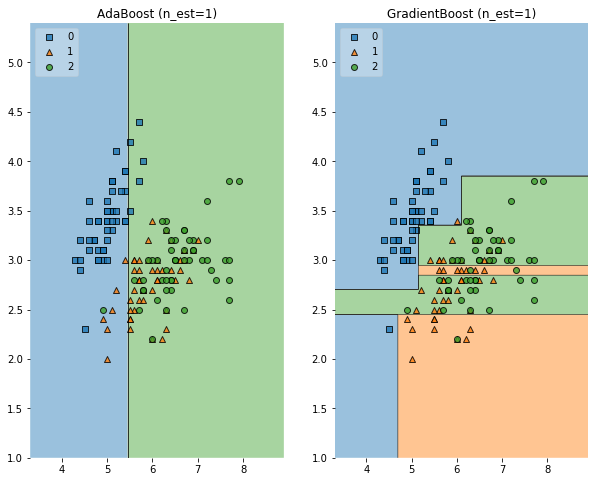

In [13]:
clf_list = [clf6, clf7]
label = ['AdaBoost (n_est=1)', 'GradientBoost (n_est=1)']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

#### 역시 예측력이 좋지 않다

### (2) tuned

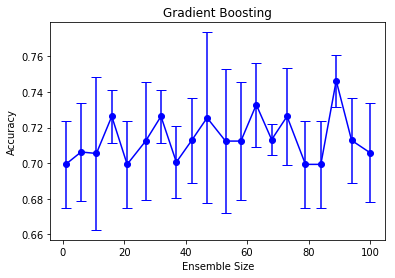

In [14]:
#Ensemble Size
num_est = np.linspace(1,100,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = RandomForestClassifier(n_estimators=n_est, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
    
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Gradient Boosting');
plt.show()

In [75]:
clf8 = GradientBoostingClassifier(random_state=0, n_estimators=90, max_features=0.8)

Accuracy: 0.72 (+/- 0.03) [GradientBoost_tuning]


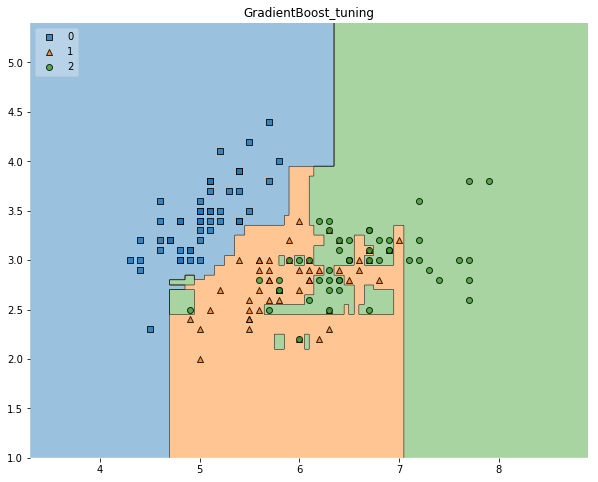

In [17]:
clf_list = [clf8]
label = ['GradientBoost_tuning']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 1)

for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    
    clf.fit(X, y)
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

#### 일부 parameter만 tuning. 예측력이 상승했다!

### by Randomized Search

In [18]:
est = GradientBoostingClassifier()
gb_p_dist={'n_estimators':[100,250,500,750],
           'max_depth':[3,5,10,None],
           'min_samples_leaf':randint(1,10),
           }

gb_parameters = hypertuning_rscv(est, gb_p_dist, 40, X, y)
print(gb_parameters)

({'max_depth': None, 'min_samples_leaf': 9, 'n_estimators': 100}, 0.7466666666666667)


Accuracy: 0.75 (+/- 0.02) [GradientBoost_RandomnizedCV]


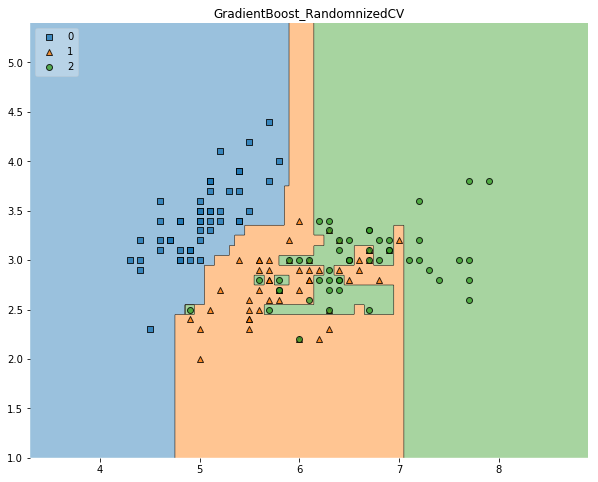

In [20]:
clf9 = GradientBoostingClassifier(max_depth = None, min_samples_leaf = 9, n_estimators = 100)

clf_list = [clf9]
label = ['GradientBoost_RandomnizedCV']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 1)

for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    
    clf.fit(X, y)
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

#### 역시 RandomSearch를 진행하였을때가 가장 높은 예측력!

### 2. XGBoost, LightGBM

In [62]:
clf10 = XGBClassifier(n_estimators=100,seed=1)
clf11 = lgbm.LGBMClassifier(n_estimators=100,seed=1)

Accuracy: 0.73 (+/- 0.01) [XGBoost]
Accuracy: 0.75 (+/- 0.03) [LightGBM]


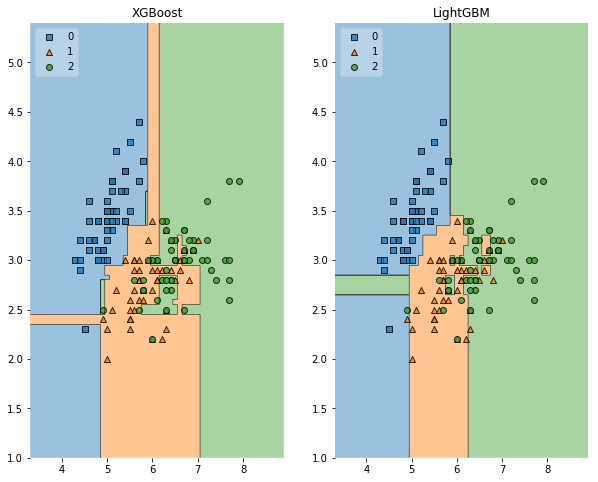

In [64]:
clf_list = [clf10, clf11]
label = ['XGBoost', 'LightGBM']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

#### Simple한 모델임에도 예측력이 높은 것을 확인할 수 있다!

# 3. Multi-Class Classification

In [77]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

clf12 = OneVsRestClassifier(LogisticRegression())
clf13 = OneVsRestClassifier(estimator = SGDClassifier(random_state=42))

Accuracy: 0.75 (+/- 0.07) [OvR Classification_Logistic]
Accuracy: 0.57 (+/- 0.06) [OvR Classification_SGD]


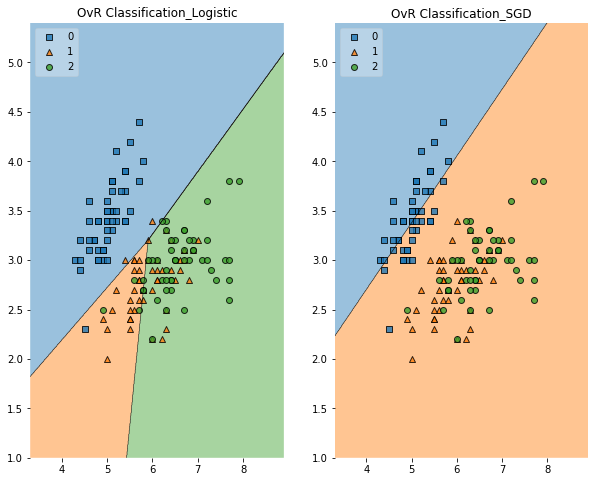

In [66]:
clf_list = [clf12, clf13]
label = ['OvR Classification_Logistic','OvR Classification_SGD']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

#### OvR 에 적용되는 구역을 나눠주는 알고리즘에 따라 성능이 크게 차이남!

# 4. Stacking

In [67]:
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

### 1. all the models above

In [78]:
label = ['Decision Tree', 'Bagging Tree' , 'Random Forest', 'Random Forest_tuning', 'RandomForest_RandomnizedCV', 'AdaBoost (n_est=1)',
         'GradientBoost (n_est=1)', 'GradientBoost_tuning','GradientBoost_RandomnizedCV','XGBoost','LightGBM','OvR Classification_Logistic', 'OvR Classification_SGD']

clf_list = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10, clf11, clf12, clf13]

for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.71 (+/- 0.06) [Bagging Tree]
Accuracy: 0.69 (+/- 0.02) [Random Forest]
Accuracy: 0.71 (+/- 0.03) [Random Forest_tuning]
Accuracy: 0.79 (+/- 0.02) [RandomForest_RandomnizedCV]
Accuracy: 0.63 (+/- 0.02) [AdaBoost (n_est=1)]
Accuracy: 0.65 (+/- 0.03) [GradientBoost (n_est=1)]
Accuracy: 0.70 (+/- 0.04) [GradientBoost_tuning]
Accuracy: 0.75 (+/- 0.02) [GradientBoost_RandomnizedCV]
Accuracy: 0.73 (+/- 0.01) [XGBoost]
Accuracy: 0.75 (+/- 0.03) [LightGBM]
Accuracy: 0.75 (+/- 0.07) [OvR Classification_Logistic]
Accuracy: 0.57 (+/- 0.06) [OvR Classification_SGD]


### 2. 2-level Stacking; with Logistic & with NN

In [79]:
lr = LogisticRegression()
nn = MLPClassifier(random_state=1)

sclf1 = StackingCVClassifier(classifiers=clf_list, 
                          meta_classifier=lr)
sclf2 = StackingClassifier(classifiers=clf_list, 
                          meta_classifier=nn)

Accuracy: 0.73 (+/- 0.08) [Stacking Classifier_Logistic]
Accuracy: 0.71 (+/- 0.03) [Stacking Classifier_NN]


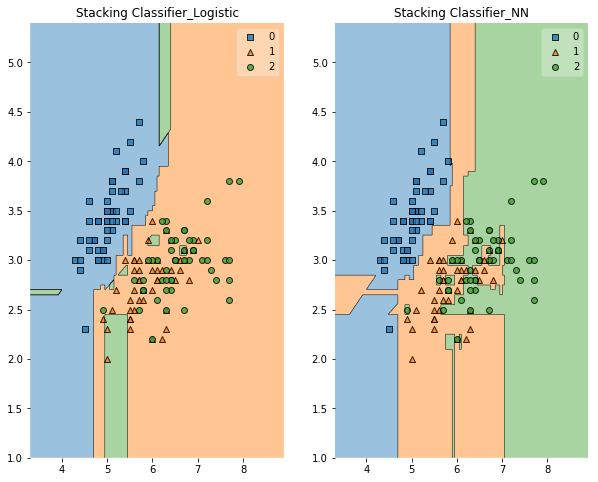

In [80]:
label = ['Stacking Classifier_Logistic', 'Stacking Classifier_NN']
clf_list = [sclf1, sclf2]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(1, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []

for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

#### 그다지 만족스럽지 못한 예측력

### 3. 3-level Stacking

In [81]:
xg = XGBClassifier(n_estimators = 100)
ada = AdaBoostClassifier(n_estimators = 100)    
nn = MLPClassifier(hidden_layer_sizes=(100,50))

sclf_xgb = StackingClassifier(classifiers=clf_list, 
                            use_probas=True,
                            average_probas=False,
                          meta_classifier=xg)
sclf_ada = StackingClassifier(classifiers=clf_list,
                            use_probas=True,
                          average_probas=False,
                          meta_classifier=ada)
sclf_nn = StackingClassifier(classifiers=clf_list,
                            use_probas=True,
                          average_probas=False,
                          meta_classifier=nn)

lr = LogisticRegression(penalty = 'l2')

sclf_fin = StackingClassifier(classifiers=[sclf_xgb, sclf_ada, sclf_nn],
                               use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

Accuracy: 0.71 (+/- 0.03) [Stacking Classifier_XGB]
Accuracy: 0.72 (+/- 0.01) [Stacking Classifier_ADA]
Accuracy: 0.71 (+/- 0.02) [Stacking Classifier_NN]
Accuracy: 0.72 (+/- 0.03) [Stacking Classifier_FIN]


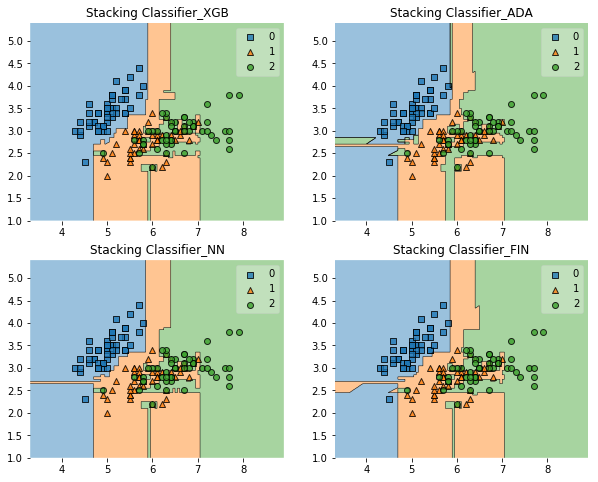

In [82]:
label = ['Stacking Classifier_XGB', 'Stacking Classifier_ADA', 'Stacking Classifier_NN', 'Stacking Classifier_FIN']
clf_list = [sclf_xgb, sclf_ada, sclf_nn, sclf_fin]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

#### 그렇게 만족스럽진 않다..

### 4. 3-level Stacking with CV 

In [83]:
xg = XGBClassifier(n_estimators = 100)
ada = AdaBoostClassifier(n_estimators = 100)    
nn = MLPClassifier(hidden_layer_sizes=(100,50))

sclf_xgb = StackingCVClassifier(classifiers=clf_list, cv=3,
                          meta_classifier=xg, random_state=1)
sclf_ada = StackingCVClassifier(classifiers=clf_list,cv=3,
                          meta_classifier=ada, random_state=1)
sclf_nn = StackingCVClassifier(classifiers=clf_list,cv=3,
                          meta_classifier=nn, random_state=1)

lr = LogisticRegression(penalty = 'l2')

sclf_fin = StackingCVClassifier(classifiers=[sclf_xgb, sclf_ada, sclf_nn],
                          meta_classifier=lr, random_state=1)

In [ ]:
label = ['StackingCV Classifier_XGB', 'StackingCV Classifier_ADA', 'StackingCV Classifier_NN', 'StackingCV Classifier_FIN']
clf_list = [sclf_xgb, sclf_ada, sclf_nn, sclf_fin]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()